## Set up

In [1]:
from dataclasses import dataclass
from pathlib import Path

import keras as tfk
# import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

sns.set_theme()

2024-11-12 18:05:25.712818: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 18:05:25.713265: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 18:05:25.716383: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 18:05:25.751353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 18:05:26.415123: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
OUTPUT_DIR = Path().absolute().parent / "results"
MODEL = "rotation_translation"
MODEL_PATH = OUTPUT_DIR / f"{MODEL}.keras"

In [3]:
model: tfk.Model = tfk.saving.load_model(MODEL_PATH)
model

<Functional name=functional_7, built=True>

In [4]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_3            │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_3 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,785,306 (14.44 MB)

 Trainable params: 262,984 (1.00 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 525,970 (2.01 MB)

### Load data

In [5]:
LOCAL_DATA_PATH = Path().absolute().parent / "data" / "training_set.npz"
DATA_PATH = LOCAL_DATA_PATH
OUTPUT_DIR = Path().absolute().parent / "submission"
# If the data is not there, then we're running in Kaggle
if not LOCAL_DATA_PATH.exists():
    print("Running on Kaggle")
    DATA_PATH = Path("/kaggle/input/an2dl-homework-1/training_set.npz")
    OUTPUT_DIR = Path()

print(DATA_PATH)
print(OUTPUT_DIR)

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz
/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/submission


In [6]:
SEED = 42
BATCH_SIZE = 32
METRICS = ["accuracy", "recall", "f1_score"]

In [7]:
tfk.utils.set_random_seed(SEED)

In [8]:
@dataclass
class Hyperparameters:
    test_size = 1500
    # Augmentation
    augmentation_fill = "wrap"
    translation_factor = (-.15, .15)
    rotation_factor = 1.0
    # Model
    layer_units = (256, 64)
    activation = "silu"
    # Training
    optimiser = tfk.optimizers.AdamW
    learning_rate = 1e-4
    loss = "categorical_crossentropy"
    epochs = 500
    ## Early stopping parameters
    es_patience = 20
    es_min_delta = 1e-5
    ## Learning rate schedule
    lr_patience = 10
    lr_decay_factor = 0.1
    min_lr = 1e-7

hp = Hyperparameters()

In [9]:
with np.load(DATA_PATH) as data:
    images = data["images"]
    labels = tfk.utils.to_categorical(data["labels"])

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 8)


In [10]:
TOLERANCE = 1e-4
MIN_DUPLICATES = 5

image_means: np.ndarray = images.mean(axis=(1, 2, 3))

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)

original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)

print(duplicated_indices.shape)
print(original_indices.shape)

clean_images = images[original_indices]
clean_labels = labels[original_indices]

(1800,)
(11959,)


In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    clean_images, clean_labels,
    test_size=hp.test_size,
    random_state=SEED,
    stratify=clean_labels,
)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(10459, 96, 96, 3)
(10459, 8)
(1500, 96, 96, 3)
(1500, 8)


### Compute predictions

In [12]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

327/327 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step


In [13]:
def decode(one_hot: np.ndarray) -> np.ndarray:
    return np.argmax(one_hot, axis=1)

In [14]:
label_train = decode(y_train)
label_val = decode(y_val)

label_train_pred = decode(y_train_pred)
label_val_pred = decode(y_val_pred)

In [15]:
outputs = {
    "train": (label_train, label_train_pred),
    "val": (label_val, label_val_pred),
}
outputs

{'train': (array([6, 1, 6, ..., 4, 2, 0]), array([6, 1, 6, ..., 4, 2, 0])),
 'val': (array([3, 2, 0, ..., 1, 2, 1]), array([3, 2, 0, ..., 1, 2, 1]))}

## Analyse

In [19]:
def confusion_diag_zero(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix[np.diag_indices_from(matrix)] = 0
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return ax

Text(0.5, 1.0, 'train')

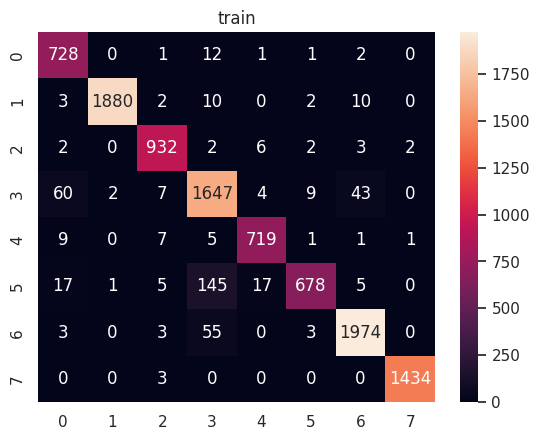

In [20]:
ax = sns.heatmap(confusion_matrix(*outputs["train"]), annot=True, fmt="d")
ax.set_title("train")

<Axes: xlabel='Predicted', ylabel='True'>

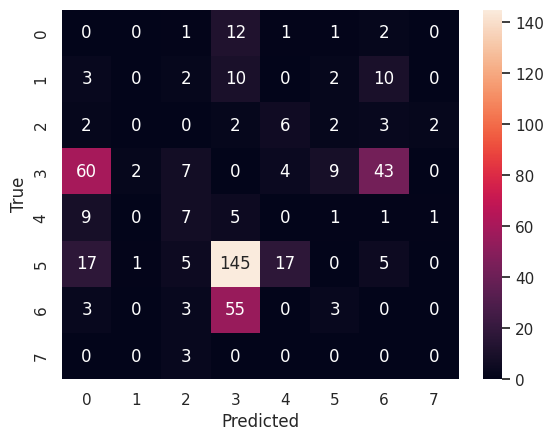

In [21]:
confusion_diag_zero(*outputs["train"])

Text(0.5, 1.0, 'val')

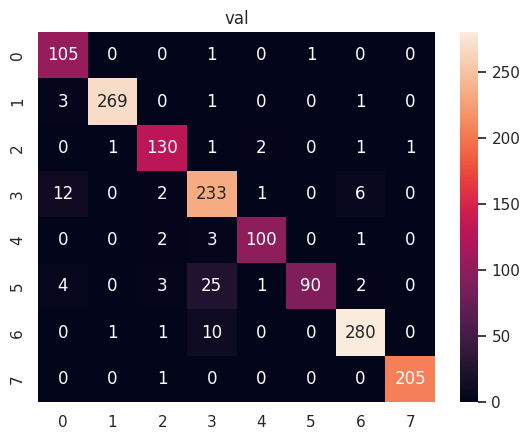

In [22]:
ax = sns.heatmap(confusion_matrix(*outputs["val"]), annot=True, fmt="d")
ax.set_title("val")

<Axes: xlabel='Predicted', ylabel='True'>

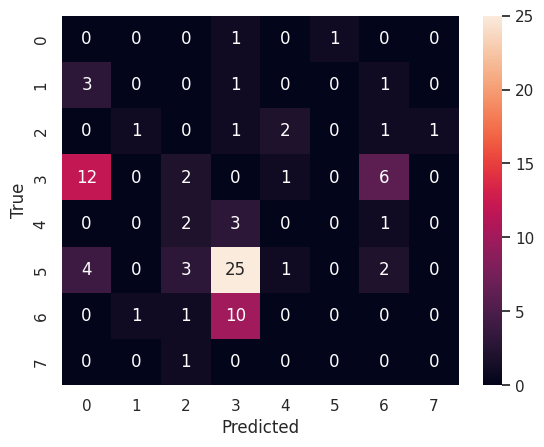

In [23]:
confusion_diag_zero(*outputs["val"])

In [28]:
for set_, (y_true, y_pred) in outputs.items():
    print(set_)
    print(classification_report(y_true, y_pred))
    print()

train
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       745
           1       1.00      0.99      0.99      1907
           2       0.97      0.98      0.98       949
           3       0.88      0.93      0.90      1772
           4       0.96      0.97      0.97       743
           5       0.97      0.78      0.87       868
           6       0.97      0.97      0.97      2038
           7       1.00      1.00      1.00      1437

    accuracy                           0.96     10459
   macro avg       0.95      0.95      0.95     10459
weighted avg       0.96      0.96      0.96     10459


val
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       107
           1       0.99      0.98      0.99       274
           2       0.94      0.96      0.95       136
           3       0.85      0.92      0.88       254
           4       0.96      0.94      0.95       106
           5 